In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')


In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence.ipynb', 'adult.data', 'adult.test', 'adult_influence.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence.ipynb', 'config.json', 'expl.py', 'functions.py', 'german.data', 'german_influence.ipynb', 'influence.py', 'load_dataset.py', 'loss.py', 'metrics.py', 'utils.py', '__pycache__']


<h4>Build model and get the influence points<h4>

In [3]:
dataset = 'german'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [4]:
X_train, X_test, y_train, y_test = load(dataset)

In [5]:
X_train

,status,duration,credit_hist,credit_amt,savings,employment,install_rate,debtors,residence,property,...,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,housing_A151,housing_A152,housing_A153
0,3,1,2,0,4,3,4,0,4,2,...,0,0,0,0,0,0,0,1,0,0
1,3,0,2,1,4,4,4,0,3,1,...,0,0,0,0,0,0,0,0,1,0
2,2,1,2,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,2,0,2,0,1,0,2,2,...,0,0,0,0,0,0,0,1,0,0
4,0,1,2,1,0,2,2,0,2,3,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,3,0,2,1,4,1,1,0,4,3,...,0,0,0,0,0,0,0,1,0,0
796,0,0,0,0,0,4,3,0,4,0,...,0,0,0,0,0,0,0,0,0,1
797,3,1,1,1,0,1,1,0,2,2,...,0,0,0,0,0,0,0,0,1,0
798,0,1,2,0,0,0,4,0,2,1,...,0,1,0,0,0,0,0,0,1,0


In [6]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [7]:
#list of solution times
sol_time = []

In [8]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [10]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.09527579578571022
Initial TPR parity:  -0.07785149123690549
Initial predictive parity:  -0.10136869457116315
Initial accuracy:  0.755


<h4>Calculate Influence of original datapoints with original labels<h4>

In [11]:
if_start = time.time()
metric_val = [spd_0, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test, dataset, metric)

In [12]:
print(metric_val)

-0.09527579578571022


In [13]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train, loss_func)

100%|██████████| 800/800 [00:10<00:00, 74.23it/s] 


In [14]:
'''

Compute the offline and online times for the influence functions
Offline: Time taken for Hessian Computation
Online: Time taken to compute influence for each of the datapoints

Break this down in the time graph; rather than showing just the total time taken for influence flipping
Break it down by offline and online

'''

'\n\nCompute the offline and online times for the influence functions\nOffline: Time taken for Hessian Computation\nOnline: Time taken to compute influence for each of the datapoints\n\nBreak this down in the time graph; rather than showing just the total time taken for influence flipping\nBreak it down by offline and online\n\n'

In [15]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train, loss_func)

In [16]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta))
#incorporate del_l_del_theta_i with the updated datapoint

In [17]:
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [18]:
inf=(1/len(X_train))*(inf)

<h4>Calculate the inf for the datapoints with a changed label using del_L_del_theta_i<h4>

In [19]:
#Flip all the labels for the encoded data and the scaled data
#The labels are the same just the training data looks different 
y_train_changed = y_train.replace({0:1,1:0})
y_test_changed = y_test.replace({0:1,1:0})

In [20]:
#Run the Classifiers and calculate the statistical parity after changing everything
#In theory it shouldnt change anything but uhhhh lets see 
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [21]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train_changed)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_1 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 0, dataset)
print("Initial statistical parity: ", spd_1)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test_changed, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test_changed, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.09501853843685237
Initial TPR parity:  0.06228146618049518
Initial predictive parity:  0.10818301462090724
Initial accuracy:  0.755


In [22]:
metric_val = [spd_1, tpr_parity_0, predictive_parity_0][metric]
del_F_del_theta = get_del_F_del_theta(clf, X_test_orig, X_test, y_test_changed, dataset, metric)

In [23]:
# Convert numpy array to tensorflow tensor
import torch 
tensor_train_attr = torch.Tensor(X_train)
tensor_train_label = torch.Tensor(y_train_changed)

In [24]:
tensor_train_label = tensor_train_label.type(torch.float64)
tensor_train_attr = tensor_train_attr.type(torch.float64)

In [25]:
del_L_del_i = []
for i in range(int(len(X_train))):
    gradient = convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], int(y_train_changed[i]), loss_func))
    del_L_del_i.append(gradient)

In [26]:
del_L_del_i = np.array(del_L_del_i)

In [27]:
hessian_all_points = get_hessian_all_points(clf, X_train, y_train_changed, loss_func)

100%|██████████| 800/800 [00:18<00:00, 43.02it/s]


In [28]:
del_L_del_theta = get_del_L_del_theta(clf, X_train, y_train_changed, loss_func)

In [29]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_i))
#incorporate del_l_del_theta_i with the updated datapoint

In [30]:
inf2 = np.matmul(np.transpose(hinv_v), del_F_del_theta)
#For the new datapoint re-calculate the hinv_v

In [31]:
inf2 = (1/len(X_train))*(inf2)

In [32]:
print(min(inf2))
print(max(inf2))

-0.0032134481659581516
0.005969756179977653


<h4>Calculate the difference between the changed vs original<h4>

In [33]:
total_inf = (inf2-inf)*-1
if_end = time.time()
if_time1 = if_start - if_end

In [34]:
print(max(total_inf))
print(min(total_inf))
print(len(total_inf))
print(type(total_inf))
print(total_inf.dtype)

0.006417935811121735
-0.011944849799115587
800
<class 'numpy.ndarray'>
float64


<h4>Flip the datapoints and remove the datapoints and compare the parity values<h4>

In [35]:

predictors = ['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'install_rate', 'debtors', 'residence', 'property', 'age',
       'install_plans', 'num_credits', 'job', 'num_liable', 'telephone',
       'foreign_worker', 'gender', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'housing_A151', 'housing_A152', 'housing_A153']
target_var =['credit_risk']

In [36]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('credit_risk')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['credit_risk'] = changed_df_labels

    return y_predicted


In [37]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [38]:
copy_train = train_full_df.copy()
difference = []

for index in copy_train.index:
    df_dropped = copy_train.copy()
    df_dropped = copy_train.drop(index)
    #Run lr_model() to get predicted probabilities
    ypred = lr_model(df_dropped, X_test, clf)
    parity = computeFairness(ypred, X_test_orig, y_test, 0, dataset)
    
    parity = parity-spd_0

    difference.append(parity)
    print(index)
#This does not fall under the measuring the time taken to decide how long it will take for IF to work 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
decimal_array = [format(num, '.10f') for num in total_inf]
decimal_array = [float(num) for num in decimal_array]
print(decimal_array)

[-0.0002686753, 0.0015361586, 3.5397e-06, -0.0009215904, 0.0009158056, -2.8205e-06, -0.0001279655, -0.000260418, -0.0024773519, 0.0011623717, -0.0005898694, 0.0001527355, -0.0022804092, -0.0037043584, 0.0019472731, 0.0018812463, 0.001246673, 0.0017234313, -0.0031311205, -0.0005590282, -0.0021502786, -0.0015186316, 0.0007281031, -0.0007683799, -0.0013817374, 0.001659064, -0.0015607814, 0.0018512426, -0.0015390628, -0.0003690226, 0.0002487197, -0.0011179289, -0.0002788687, 0.0029534075, -0.0017069861, -0.0002771268, -0.0009641917, 0.0022770328, 0.0016082337, -0.0003615758, 0.00086947, -7.48187e-05, 0.0025285921, 0.0015420282, 0.0001384701, -0.0003633256, -0.0026699979, 0.0024391042, 1.44492e-05, -0.0001323805, -0.0004341449, -0.0001247013, -0.0058159899, -0.0026436573, -0.0013187566, -0.0002749039, -0.0006557865, 0.0023524982, -0.0013126126, -0.0004995668, -0.0001425061, -0.0001395906, 0.0008168767, 0.0007905327, 0.0018031542, -1.3145e-05, -0.0021327208, -0.0006912118, -8.25597e-05, -0.0

In [40]:
print(difference)

[-0.00031276005320246547, 0.0012296149972825798, 0.0004472514148801121, -4.204479046165943e-05, 0.0009012604597956608, 0.00043631778098640606, 0.0003764403983950171, 0.0003076230641454458, -0.0008628618903457896, 0.001044445578008979, 0.00013030641712241664, 0.0005219431128352658, -0.0007302267942577156, -0.0016043666750192864, 0.0014366694726050122, 0.0014173496514559014, 0.001078637223690726, 0.0013204615563153776, -0.0011724360287188595, 0.00015915920957920715, -0.0006672123447060141, -0.000361656164750368, 0.0008112838491797225, 4.381914623075023e-05, -0.0003712643403559479, 0.001289883349090748, -0.0003633887507020761, 0.001382097601890564, -0.00035963798873117625, 0.0002523798029869795, 0.0005662076175212416, -0.0001273179892450349, 0.00029773805290456146, 0.0019410730805247134, -0.00044489656575019687, 0.00029713688418264717, -5.442514084275096e-05, 0.0016401707194745319, 0.001261846441775627, 0.00026417956687507793, 0.0009184852708130631, 0.0003973295912146346, 0.00174766262061

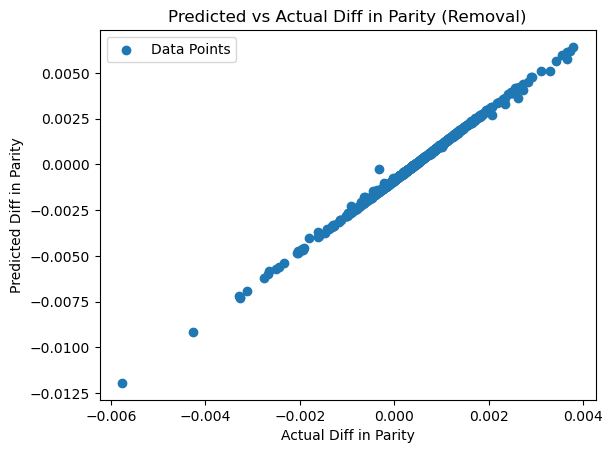

In [41]:
# Assuming your lists are named `predicted_diff` and `actual_diff`
predicted_diff = decimal_array
actual_diff = difference

# Create the scatter plot
plt.scatter(actual_diff, predicted_diff, label='Data Points')

# Set the labels for the axes
plt.xlabel('Actual Diff in Parity')
plt.ylabel('Predicted Diff in Parity')

# Set the title of the plot (optional)
plt.title('Predicted vs Actual Diff in Parity (Removal)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<h3>##########################################################################################<h3>

<h4>Make flips based on the total_inf value<h4>

In [42]:
if_start = time.time()
index_list = []
for i in range(800):
    index_list.append(i)

In [43]:
#Make a copy of the training data to make flips on 
influence_train_copy = train_full_df.copy()

In [44]:
#Order the total_inf in descending order based on magnitude
combined_list = list(zip(total_inf, index_list))

# Step 2: Sort the combined list based on the float values
sorted_combined_list = sorted(combined_list, key=lambda x: abs(x[0]), reverse=True)

# Step 3: Unpack the sorted list of tuples back into two separate lists
abs_sorted_float_list, abs_sorted_index_list = zip(*sorted_combined_list)
list(abs_sorted_float_list)
list(abs_sorted_index_list)
#Measure up to here for the influence functions
#This will tell us how long it takes for influence functions to determine which order I need to flip the datapoints in
#if_time: Time taken to decide the order in which the datapoints need to be flipped
if_end = time.time()
if_time2 = if_end-if_start
if_time2 += if_time1
print(if_time2)

-31.19466781616211


In [45]:
if if_time2 < 0:
    if_time2 = -1 * if_time2
else: 
    pass

In [46]:
flip_parity_abs = []
for i in range(len(abs_sorted_index_list)):
    row_num = abs_sorted_index_list[i]
    if influence_train_copy.at[row_num,'credit_risk'] == 1:
        influence_train_copy.at[row_num,'credit_risk'] = 0
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
    elif influence_train_copy.at[row_num,'credit_risk'] == 0:
        influence_train_copy.at[row_num,'credit_risk'] = 1
        influence_prediction = lr_model(influence_train_copy, X_test, clf)
        influence_parity = computeFairness(influence_prediction, X_test_orig, y_test, 0, dataset)
        flip_parity_abs.append(influence_parity)
print(flip_parity_abs)

[-0.10217928956262767, -0.10753714428283279, -0.11207302962429821, -0.11622929102741175, -0.12125294809229681, -0.12659075600095093, -0.12146631195209923, -0.1164486621506512, -0.1210414370056242, -0.11648934679105882, -0.1209532676730305, -0.11600849037058658, -0.11992156687192612, -0.11489750784821817, -0.11907284888438874, -0.11389762340113518, -0.1176880967337639, -0.1224988904315979, -0.11609309646300969, -0.11294396608136592, -0.11619227351620787, -0.12109634047374129, -0.11697704493999483, -0.11235624612309036, -0.1171635868493468, -0.12069160663522782, -0.1236727877985686, -0.1286631932482123, -0.13226142367348082, -0.12754662889055912, -0.1218870937824249, -0.11724128923378885, -0.1143254169728607, -0.11111117317341268, -0.10591282146051517, -0.10112892123870554, -0.10429657637141654, -0.10836032745428381, -0.10556698678992693, -0.09946359675377603, -0.10397339127957828, -0.10118116145022216, -0.09581840974278744, -0.09160454873926938, -0.08911148323677487, -0.0917308003176003

In [47]:
sol_time.append(if_time2)

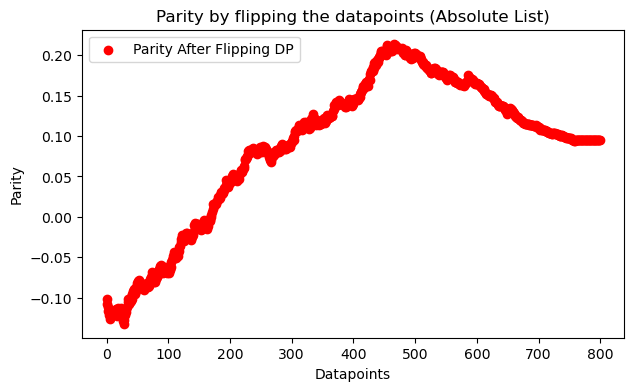

In [48]:
#Graph the points
# Assuming the X-axis is some common range or specific values
size = range(len(flip_parity_abs))  # X values for list data

# Create the plot
plt.figure(figsize=(7, 4))

# Plot list data with dots
plt.scatter(size, flip_parity_abs, color='red', label='Parity After Flipping DP', marker='o')

# Adding labels
plt.xlabel('Datapoints')
plt.ylabel('Parity')

# Adding title and legend
plt.title('Parity by flipping the datapoints (Absolute List)')
plt.legend()

# Display the plot
plt.show()

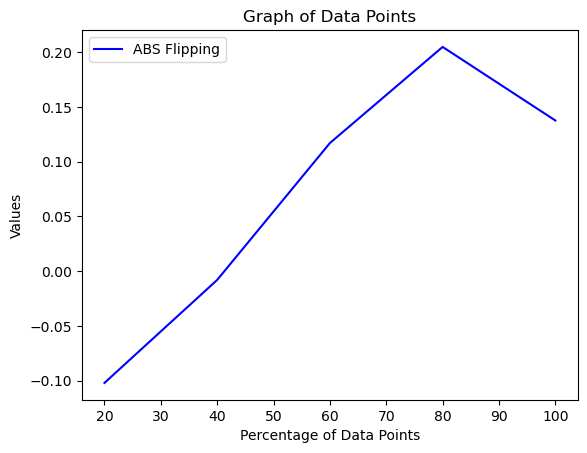

In [49]:
#total num of data points
#on_abs_sorted = len(flip_parity_sorted)
abs_sorted = len(flip_parity_abs)

#Calculate the indices for the 5 points
#indices_non_abs = [int(i * non_abs_sorted / 5) for i in range(0, 5)]
indices_abs = [int(i * abs_sorted / 5) for i in range(0, 5)]

# Extract the values at these indices
#values_non_abs = [flip_parity_sorted[index] for index in indices_non_abs]
values_abs = [flip_parity_abs[index] for index in indices_abs]

#Plot the Values
plt.plot([20, 40, 60, 80, 100], values_abs, label='ABS Flipping', color='Blue')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()

<h3>Compare methods of: Naive, Entropy, MEU, and IF<h3>

<h5>Naive Method: Greedy Algorithm<h5>

In [50]:
greedy_start = time.time()
#Beginning of the Greedy Algorithm
#Make the original flips to test for the parity after each flip 
greedy_train = train_full_df.copy()
greedy_parity_list = []

for index, row in greedy_train.iterrows():
    if row['credit_risk'] == 1:
        #Flip the label at credit_risk = 1 to 0
        greedy_train.at[index,'credit_risk'] = 0
        greedy_pred = lr_model(greedy_train, X_test, clf)
        greedy_parity = computeFairness(greedy_pred, X_test_orig, y_test, 0, dataset)
        greedy_parity_list.append(greedy_parity)
        greedy_train.at[index,'credit_risk'] = 1
        
    elif row['credit_risk'] == 0:
        greedy_train.at[index,'credit_risk'] = 1
        greedy_pred = lr_model(greedy_train, X_test, clf)
        greedy_parity = computeFairness(greedy_pred, X_test_orig, y_test, 0, dataset)
        greedy_parity_list.append(greedy_parity)
        greedy_train.at[index,'credit_risk'] = 0

In [51]:
#Compare each of the parity values after flipping to the OG parity value
#Append to a new list

#parity_difference: Contains the difference between flipped and original value
parity_difference = []
#Contains parity values that fall between .03 and -.03
large_influence = []
#Contains the row number of each flip
li_row = []

for value in greedy_parity_list:
    difference = abs(value) - abs(spd_0)
    parity_difference.append(difference)

#Rows considered to be high influence if they in between a specific value
for index, item in enumerate(parity_difference):
  if spd_0 > 0:
    if item <= spd_0 or item >= -1*(spd_0):
        large_influence.append(item)
        li_row.append(index)
  else:
    if item >= spd_0 or item <= -1*(spd_0):
        large_influence.append(item)
        li_row.append(index)

In [52]:
# Combine lists into tuples and zip them
combined_data = list(zip(large_influence, li_row))

# Sort based on statistical parity values in descending order
combined_data.sort(key=lambda x: abs(x[0]), reverse=True)

# Extract sorted indices list and the sorted values
sorted_indices_list = [index for _, index in combined_data]
sorted_values = sorted(large_influence, reverse=True)
greedy_end = time.time()

In [53]:
#After ranking the values now go back through the dataset flipping 
#based on the ranked values

#Parity values after each flip
ranked_greedy_parity_list = []
#Accuracy after every flip
ranked_acc = []
#Index/row of the flip
ranked_flip = []

row_num = 0
ranked_indices_list = list(sorted_indices_list)

#Iterate through the ranked list and start the flipping
for idx, row in enumerate(ranked_indices_list):
    row_num = ranked_indices_list[row]
    #If the label at the specific row is 1 it flips it to 0 then calculates the parity and accuracy
    #It follows the same steps as the flipping before
    if greedy_train.at[row_num,'credit_risk'] == 1:
        greedy_train.at[row,'credit_risk'] = 0
        ranked_greedy_pred = lr_model(greedy_train, X_test, clf)
        ranked_greedy_parity = computeFairness(ranked_greedy_pred, X_test_orig, y_test, 0, dataset)
        ranked_greedy_parity_list.append(ranked_greedy_parity)
    elif greedy_train.at[row_num, 'credit_risk'] == 0:
        greedy_train.at[row, 'credit_risk'] = 1
        ranked_greedy_pred = lr_model(greedy_train, X_test, clf)
        ranked_greedy_parity = computeFairness(ranked_greedy_pred, X_test_orig, y_test, 0, dataset)
        ranked_greedy_parity_list.append(ranked_greedy_parity)

In [54]:
greedy_time = greedy_end - greedy_start
sol_time.append(greedy_time)

<h4>Uncertainty Reduction/Entropy<h4>

In [55]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [56]:
#Run the LR classifier
#Use Scikit learn logistic regression rather than pre-built one
clfa = LogisticRegression(class_weight=None, max_iter=100)
log = clfa.fit(X_train,y_train)
prediction = log.predict(X_test)
#prediction_prob = log.predict_proba(X_train)
accuracy = accuracy_score(y_test,prediction)*100
print(accuracy)

75.5


In [57]:
#Obtain the predicted probabilities
predicted_prob = log.predict_proba(X_train)

In [58]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_prob):
  #Calculate p1 and p2
  p1=predicted_prob[index,0]
  p2=predicted_prob[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [59]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time()

In [60]:
entropy_train_df['credit_risk'] = entropy_train_df['credit_risk'].astype('int')

In [61]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [62]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

ranked_ent_parity_list = [spd_0]
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'credit_risk'] == 0:
        entropy_train_df.at[row_num,'credit_risk'] = 1
        ranked_ent_pred = lr_model(greedy_train, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'credit_risk'] == 1:
        entropy_train_df.at[row_num,'credit_risk'] = 0
        ranked_ent_pred = lr_model(greedy_train, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [63]:
entropy_time = entropy_end - entropy_start
sol_time.append(entropy_time)

<h4>Maximum Expected Utility<h4>

In [64]:
#Copy training dataset
meu_start = time.time()
meu_training_df = train_full_df.copy()

In [65]:
#Obtain the predicted probabilities 
meu_pred_prob = log.predict_proba(X_train)

In [66]:
#Grab the original of the DP in the copy dataframe and sotre in lists along with the index
label = []
row_index = []
for index, row in meu_training_df.iterrows():
    label.append(meu_training_df.at[index,'credit_risk'])
    row_index.append(index)

In [67]:
#Calculate the first part of the MEU equation
meu_part1_list = []
for index, value in enumerate(label):
    if value == 1:
        prob1 = meu_pred_prob[index,1]
        meu_part1_calc = prob1 * spd_0
        meu_part1_list.append(meu_part1_calc)
    elif value == 0:
        prob2 = meu_pred_prob[index,0]
        meu_part1_calc = prob2 * spd_0
        meu_part1_list.append(meu_part1_calc)

In [68]:
#Iterate through the copied dataset and flip each lable and calculate the parity

meu_part2_parity_list = []

for idx, row in meu_training_df.iterrows():
    #If the row is positive then flip it to negative
    if row['credit_risk'] == 1:
        meu_training_df.at[index,'credit_risk']= 0
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df.at[index,'credit_risk'] = 1
    #If negative then flip to positive
    elif row['credit_risk'] == 0:
        meu_training_df.at[index,'credit_risk']= 1
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df.at[index,'credit_risk'] = 0
        

In [69]:
#Second part of the calculation by taking the opposite value
meu_part2_list = []
for index, value in enumerate(label):
    if value == 0:
        prob0 = meu_pred_prob[index,0]
        meu_part2_calc = prob0* meu_part2_parity_list[index]
    elif value == 1:
        prob1 = meu_pred_prob[index,1]
        meu_part2_calc = prob1 * meu_part2_parity_list[index]
        meu_part2_list.append(meu_part2_calc)


In [70]:
#Add the two lists together
expected_utility_values = []
for part1, part2 in zip(meu_part1_list, meu_part2_list):
    expected_utility_values.append(part1+part2)

In [71]:
#EU - OG Parity = new ranked values
new_ranked_value = []

for value in expected_utility_values:
    new_ranked_value.append(value - spd_0)

In [72]:
#Rank the values
combined_list = list(zip(new_ranked_value,row_index))
sorted_list = sorted(combined_list, key = lambda x: abs(x[0]), reverse=True)
sorted_eu_list, sorted_index_list = zip(*sorted_list)
meu_end = time.time()

In [73]:
#After ranking flip the values
meu_ranked_parity_list = [spd_0]

for row in range(len(sorted_index_list)):
    row_num = sorted_index_list[row]
    
    if meu_training_df.at[row_num,'credit_risk'] == 1:
        meu_training_df.at[row_num, 'credit_risk'] = 0
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)
    elif meu_training_df.at[row_num, 'credit_risk'] == 0:
        meu_training_df.at[row_num, 'credit_risk'] = 1
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)

In [74]:
meu_time = meu_end - meu_start
sol_time.append(meu_time)

<h4>Randomized flipping<h4>

In [75]:
#Training dataset
random_start = time.time()
random_training_df = train_full_df.copy()

In [76]:
#Budget of 200 random flipping
import random
random_flip_parity = []
budget = 200

for iter in range(200):
    random_row = random.choice(random_training_df.index)
    if random_training_df.at[random_row,'credit_risk'] == 1:
        random_training_df.at[random_row,'credit_risk'] = 0
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
    elif random_training_df.at[random_row,'credit_risk'] == 0:
        random_training_df.at[random_row,'credit_risk'] = 1
        rand_pred = lr_model(random_training_df, X_test, clf)
        rand_ranked_parity = computeFairness(rand_pred, X_test_orig, y_test, 0, dataset)
        random_flip_parity.append(rand_ranked_parity)
random_end = time.time()


In [77]:
random_time = random_end - random_start
sol_time.append(random_time)

In [78]:
if_start

1724697521.6405978

<h4>Graph of outcomes<h4>

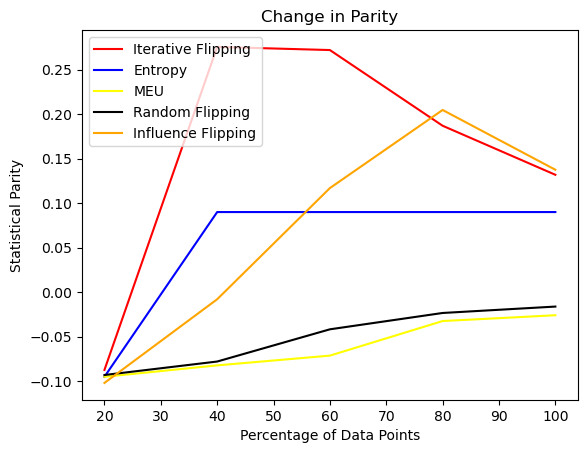

In [79]:
# Calculate the total number of data points
datapoints_iterative = len(ranked_greedy_parity_list)
datapoints_entropy = len(ranked_ent_parity_list)
datapoints_meu = len(meu_ranked_parity_list)
datapoints_random = len(random_flip_parity)
datapoints_influence = len(flip_parity_abs)

# Calculate the indices for the 5 points
indices_iterative = [int(i * datapoints_iterative / 5) for i in range(0, 5)]
indices_entropy = [int(i * datapoints_entropy / 5) for i in range(0, 5)]
indices_meu = [int(i * datapoints_meu / 5) for i in range(0, 5)]
indices_random = [int(i * datapoints_random / 5) for i in range(0, 5)]
indices_influence = [int(i * datapoints_influence / 5) for i in range(0, 5)]

# Extract the values at these indices
values_iterative = [ranked_greedy_parity_list[index] for index in indices_iterative]
values_entropy = [ranked_ent_parity_list[index] for index in indices_entropy]
values_meu = [meu_ranked_parity_list[index] for index in indices_meu]
values_random = [random_flip_parity[index] for index in indices_random]
values_influence = [flip_parity_abs[index] for index in indices_influence]

# Plot the values
plt.plot([20, 40, 60, 80, 100], values_iterative, label='Iterative Flipping', color='Red')
plt.plot([20, 40, 60, 80, 100], values_entropy, label='Entropy', color='Blue')
plt.plot([20, 40, 60, 80, 100], values_meu, label='MEU', color='Yellow')
plt.plot([20, 40, 60, 80, 100], values_random, label='Random Flipping', color='Black')
plt.plot([20, 40, 60, 80, 100], values_influence, label='Influence Flipping', color='Orange')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Statistical Parity')
plt.title('Change in Parity')
plt.legend()

<h4>Time Comparisons<h4>

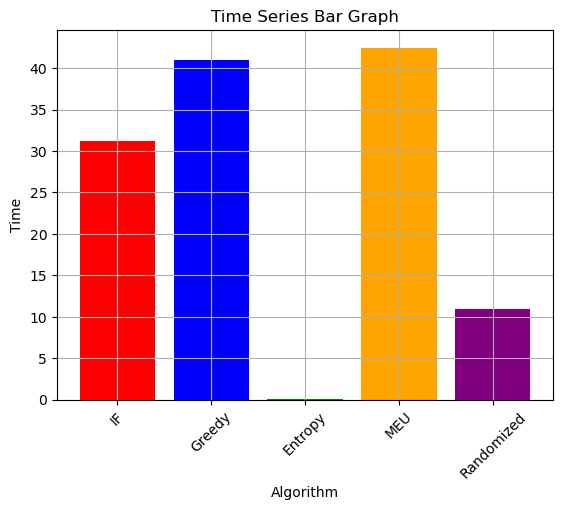

In [80]:
# Create a line chart
x_axis = ['IF', 'Greedy', 'Entropy', 'MEU', 'Randomized']
# Colors for each bar
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Create a bar graph with updated labels and colors
plt.bar(x_axis, sol_time, color=colors)
plt.title('Time Series Bar Graph')
plt.xlabel('Algorithm')
plt.ylabel('Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [81]:
#When calculating the time we are looking at the time taken to choose which datapoint to flip 
#Do not consider the time taken to calculate the fairness on each datapoint
#Also when implementing the other solutions on the bigger datasets do not implement MEU and greedy due to the expense of it
#Instead implement IF, Entropy, and randomized

#Since our solution is looking to determine the efficiency at which the datapoints are selected we want to measure the time 
#taken to determine which order the datapoints should be flipped in
#Measure how long it takes to determine which datapoints need to be flipping and do not consider the parity calculations
print(sol_time)

[31.19466781616211, 41.026294469833374, 0.0667109489440918, 42.45032572746277, 10.917543411254883]
